# Nadir Video Transformation
This notebook demonstrates how to perform coordinate transformation for nadir (top-down) river videos (from UAV/drones) using RIVeR. We'll focus on converting pixel coordinates to real-world coordinates using ground reference points (GRPs).

## Prerequisites
- Completed frame extraction (00_introduction.ipynb)
- GRP measurements from field survey
- A nadir view frame to work with

In [ ]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import cv2
import json

# Import RIVeR modules using relative imports
from river.core.coordinate_transform import (
    get_uav_transformation_matrix,
    transform_pixel_to_real_world,
    transform_real_world_to_pixel
)


# Set up paths
frame_path = Path("data/frames/yanuncay/0000005301.jpg")
# Save transformation data
output_dir = Path("results/yanuncay")
output_dir.mkdir(parents=True, exist_ok=True)

## Step 1: Load and Display the Frame
First, we'll load our sample frame and prepare it for transformation.

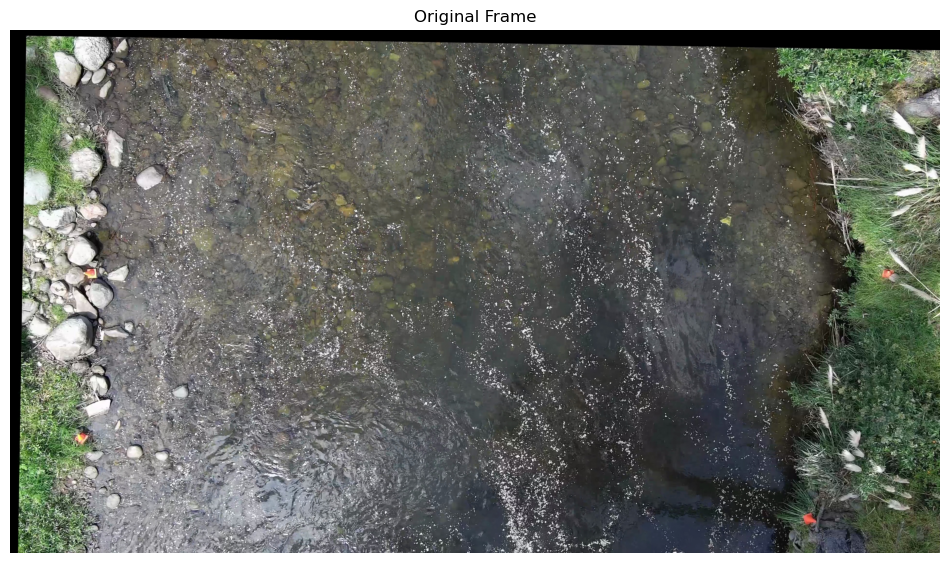

In [ ]:
# Load the image
frame = cv2.imread(str(frame_path))
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

# Display the frame
plt.figure(figsize=(12, 8))
plt.imshow(frame_rgb)
plt.axis('off')
plt.title('Original Frame')
plt.show()

## Step 2: Define Ground Control Points (GRPs)
For nadir transformation, we need at least two GRPs to establish scale. More points improve accuracy.

In [ ]:
# Example GRP coordinates (replace with your actual measurements)
# Format: pixel coordinates (x, y) and real-world coordinates (east, north) in meters
gcp_pixel = {
    'point1': (343.4, 1009.2),  # Left point in pixels
    'point2': (3626.1, 1005.3)  # Right point in pixels
}

gcp_world = {
    'point1': (0, 0),       # Left point in meters
    'point2': (15.85, 0)      # Right point in meters (15.85m distance)
}

# Extract coordinates for transformation
x1_pix, y1_pix = gcp_pixel['point1']
x2_pix, y2_pix = gcp_pixel['point2']
x1_rw, y1_rw = gcp_world['point1']
x2_rw, y2_rw = gcp_world['point2']

# Calculate transformation matrix
transformation = get_uav_transformation_matrix(
    x1_pix, y1_pix,
    x2_pix, y2_pix,
    x1_rw, y1_rw,
    x2_rw, y2_rw,
    image_path = frame_path
)

transformation_matrix = transformation['transformation_matrix']
# Save transformation matrix to JSON
output_dir = Path("results/yanuncay")
output_dir.mkdir(parents=True, exist_ok=True)

# Save to JSON file
output_file = output_dir / "transformation.json"
with open(output_file, 'w') as f:
    json.dump(transformation_matrix, f, indent=2)
print(f"Transformation matrix saved to {output_file}")

# Save the transformed image
image_output_file = output_dir / "orthorectified.png"
plt.imsave(str(image_output_file), transformation['transformed_img'])
print(f"Transformed image saved to {image_output_file}")

Using resolution: 0.0408 units/pixel
Output image dimensions: 500 x 281 pixels
Transformation matrix saved to results/yanuncay/transformation.json
Transformed image saved to results/yanuncay/orthorectified.png


## Step 3: Visualize the Transformation
Let's visualize how pixel coordinates map to real-world coordinates.

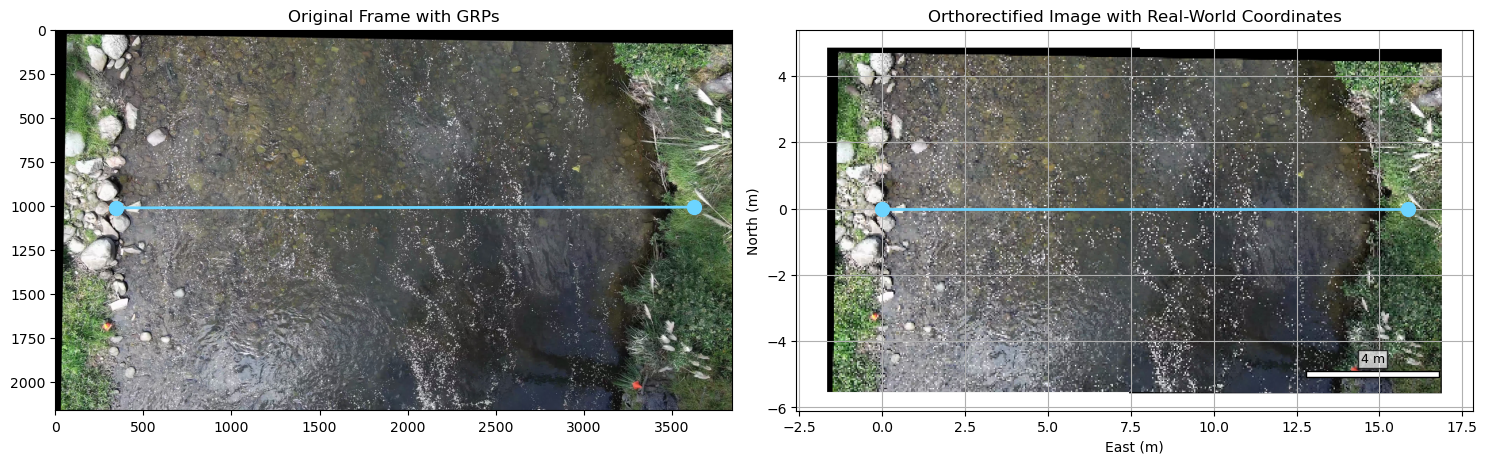

In [ ]:
def plot_transformation_check(frame_rgb, gcp_pixel, gcp_world, transformation_matrix, transformation=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot original image with pixel GRPs
    ax1.imshow(frame_rgb)
    ax1.plot([gcp_pixel['point1'][0], gcp_pixel['point2'][0]], 
             [gcp_pixel['point1'][1], gcp_pixel['point2'][1]], 
             '-', color='#6CD4FF', linewidth=2)
    ax1.plot([x1_pix, x2_pix], [y1_pix, y2_pix], 'o', color='#6CD4FF', markersize=10)
    ax1.set_title('Original Frame with GRPs')
    
    # Create real-world coordinate visualization
    real_world_points = []
    for x, y in [(x1_pix, y1_pix), (x2_pix, y2_pix)]:
        rw_point = transform_pixel_to_real_world(x, y, transformation_matrix)
        real_world_points.append(rw_point)
    
    real_world_points = np.array(real_world_points)
    
    # Plot transformed image in the second subplot with extent
    if transformation is not None and 'transformed_img' in transformation and 'extent' in transformation:
        extent = transformation['extent']
        ax2.imshow(transformation['transformed_img'], 
                   extent=extent)
        
        # Add scale bar
        # Calculate appropriate scale length
        map_width = extent[1] - extent[0]
        magnitude = 10 ** np.floor(np.log10(map_width * 0.2))
        scale_length = np.round(map_width * 0.2 / magnitude) * magnitude
        scale_length_rounded = int(scale_length) if scale_length < 10 else scale_length
        
        # Define scale bar position (in data coordinates)
        margin = (extent[1] - extent[0]) * 0.05  # 5% margin from edges
        bar_height = (extent[3] - extent[2]) * 0.015  # Height of bar
        x_pos = extent[1] - margin - scale_length_rounded
        y_pos = extent[2] + margin
        
        # Add scale bar
        rect = Rectangle((x_pos, y_pos), scale_length_rounded, bar_height,
                         fc='white', ec='black')
        ax2.add_patch(rect)
        
        # Add text label for the scale bar
        ax2.text(x_pos + scale_length_rounded/2, y_pos + 2*bar_height,
                f'{int(scale_length_rounded)} m',
                ha='center', va='bottom', fontsize=9,
                bbox=dict(facecolor='white', alpha=0.7, pad=2))
    
    # Plot real-world coordinates
    ax2.plot(real_world_points[:, 0], real_world_points[:, 1], color='#6CD4FF', linewidth=2)
    ax2.plot(real_world_points[:, 0], real_world_points[:, 1], 'o', color='#6CD4FF', markersize=10)
    ax2.set_xlabel('East (m)')
    ax2.set_ylabel('North (m)')
    ax2.grid(True)
    ax2.set_title('Orthorectified Image with Real-World Coordinates')
    
    plt.tight_layout()
    plt.show()

# Create the visualization
plot_transformation_check(frame_rgb, gcp_pixel, gcp_world, transformation_matrix, 
                          transformation=transformation)

### Common Issues and Troubleshooting
1. Transformation appears skewed:
   - Verify GCP measurements accuracy
   - Check for lens distortion effects
   - Consider adding more GCPs

2. Scale issues:
   - Confirm units consistency (meters vs pixels)
   - Verify GCP distance measurements

3. Poor alignment:
   - Check GCP pixel coordinate selection
   - Consider camera position/angle effects

## Next Steps
1. Save the transformation matrix for use in velocity calculations
2. Proceed to PIV analysis using the transformed coordinates
3. Document transformation parameters for reproducibility

The transformation matrix and validation results should be saved for use in subsequent analysis steps. Proceed to the PIV analysis notebook once you're satisfied with the transformation accuracy.